# Disaster aware isochrones with openrouteservice

# Introduction

During times of disaster, such as the devastating flood event in Germany's Ahr valley in July 2021, isochrones can support emergency responders, humanitarian organizations, and disaster management teams. Openrouteservice, an open-source routing engine utilizing OpenStreetMap data, offers a flexible and powerful solution for generating isochrones and addressing logistical challenges in such critical situations.

This training aims to familiarize participants with the capabilities of openrouteservice's isochrone generation within R and demonstrate how it can be leveraged to enhance disaster response planning. Through a series of code examples, we will explore the key features and functionalities of openrouteservice's isochrone API. You will learn how easy it is to interact with openrouteservice from R and be able to integrate isochrone analysis directly into your own workflow.

By utilizing openrouteservice's isochrone capabilities, participants will gain the ability to analyze and visualize travel time polygons, highlighting areas reachable within specific time thresholds. This information is invaluable for identifying high-priority locations, optimizing evacuation routes, and strategically positioning resources during emergencies. Through hands-on exercises, you will learn how to customize isochrone parameters, such as travel modes, durations, and destination points, to tailor the analysis to your specific needs.


## Setup

Before we delve into the details of utilizing openrouteservice, let's ensure that we have all the necessary prerequisites in place. The following code chunk provides instructions on how to install the required packages. The openrouteservice R library is currently not published on CRAN, but can be conveniently installed through the devtools packages `install_github` function. Same applies to the exactextract library, it provides us with a set of methods to conduct zonal statistic methods.


Load libraries we will need for this training:

In [11]:
from openrouteservice import client
from openrouteservice.exceptions import ApiError
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
import rasterio as rio
import folium
import folium.plugins
from rasterstats import zonal_stats

#### Get openrouteservice API key
In order to use the openrouteservice public API you need to register yourself an account and create an api key.

-   Sign up here: [openrouteservice.org/dev/#/login](https://openrouteservice.org/dev/#/login)
-   Or consult our step by step guide as part of the resources we've provided you in the workshop book here: [giscience.github.io/openrouteservice-workshop](https://giscience.github.io/openrouteservice-workshop)

When you sucessfully created your personal api key, copy it over in the chunk below.


In [3]:
api_key = '5b3ce3597851110001cf6248eef794d1244544f7826f417356aee9e4'

## Context

During the Ahr valley flood event, many roads and bridges were damaged or rendered impassable, posing significant challenges for navigation and transportation. You may have already done the other exercise on disaster aware routing in the Ahr valley during the flood disaster. There we used the avoid areas parameter of openrouteservices directions endpoint to calculate routes which do not intersect with determined areas, in this very case bridges and roads destroyed by the flood. But openrouteservice can also combine avoid areas with isochrones.

What is an isochrone again?

*An isochrone is a geographical representation of areas that can be reached within a specified travel time or distance from a given location.*

## Single isochrone and avoid areas

Let's try it out. In the following code chunk we define a location in the city of Bad Neunahr-Ahrweiler. We then pass the coordinates to accompanied by some options for the isochrone service API parameters. Contrary to the directions api, we only need one coordinate. It serves as the center from which the isochrone is calculated. We can add more options, customizing our request. Many options are the same to directions. So there is also a profile, that is the option of mode of transport, e.g. car, oby foot or by bicycle. Or the shortest or fastest route. Isochrones specific are for example range_type, range and interval. Range type specifies the unit of measurement of time or distance. Range specifies the total range. With the option interval partial isochrones can be calculated at the same time. For this example, we use time as the unit and a total range of 20 minutes divided into intervals of 5.


#### Set up ORS client

In [7]:
ors_client = client.Client(key=api_key)

For the isochrones requests with avoid areas we will use a custom client. In the same way, you could also query a local ORS instance. 

In [8]:
ors_client_custom = client.Client(key=api_key, base_url='https://api.openrouteservice.org')

## Isochrones from Bad Neuanahr-Ahrweiler before the flood

**Set center of isochrones** to a location in Bad Neuenahr 

In [15]:
badneuenahr_coordinates = [7.119166, 50.548979]
badneuenahr_df = gpd.GeoDataFrame({'geometry': [Point(badneuenahr_coordinates)], 'name': ['Bad Neuenahr']}, crs="epsg:4326")

**Load damaged roads and bridges** which should be avoided

In [16]:
affected_roads_bridges = gpd.read_file("../resources/data/ahrtal/affected_roads.gpkg")
affected_roads_bridges['id'] = affected_roads_bridges.index
affected_places = gpd.read_file("../resources/data/ahrtal/affected_places.gpkg")

To pass the damaged roads to ORS, we need to **convert them to one single polygon.**

In [17]:
affected_roads_bridges_union = affected_roads_bridges.copy()
affected_roads_bridges_union.geometry = affected_roads_bridges_union.geometry.to_crs('25832').buffer(2).to_crs('4326').make_valid()
affected_roads_bridges_union = affected_roads_bridges_union.dissolve()
affected_roads_bridges_union.geometry = affected_roads_bridges_union.make_valid()

#### Set the request parameters

We want to know how far you can go by car whithin 5, 10, 15 and 20 minutes 

In [18]:
profile = 'driving-car'
isochrones_parameters = {
    'locations': [badneuenahr_coordinates],
    'profile': profile,
    'range_type': 'time',
    'range': [1200], # seconds 
    'interval': 300, # seconds
}

For the flood scenario, we will add the roads that should be avoided to the request parameters. 

In [19]:
isochrones_parameters_flood = isochrones_parameters.copy()
isochrones_parameters_flood['options'] = {'avoid_polygons': mapping(affected_roads_bridges_union.make_valid().geometry[0])}

### Query openrouteservice

Query the **isochrones without avoided areas** and convert to `GeoDataFrame`

In [20]:
isochrones = ors_client.isochrones(**isochrones_parameters)
isochrones_df = gpd.GeoDataFrame.from_features(isochrones).set_crs(epsg=4326)

Query the **isochrones with avoided areas** and convert to `GeoDataFrame`

In [21]:
isochrones_flood = ors_client_custom.request(url="/v2/isochrones/{}/geojson".format(profile), post_json=isochrones_parameters_flood)
isochrones_flood_df = gpd.GeoDataFrame.from_features(isochrones_flood).set_crs(epsg=4326)

### Isochrones on the map 

Let's create a map to compare the isochrones before and after the flood. Can you spot the difference?

Look south of the center of the isochrones. This area is not reachable according to the disaster aware isochrone in 20 minutes. We further see some hints about the infrastructure. Both isochrones extend quite far from south east to north west. This is due to the *Autobahn* *A61*.

In [50]:
m = folium.plugins.DualMap(location=badneuenahr_coordinates[::-1], 
                           tiles='cartodbpositron', 
                           zoom_start=10)
isochrones_df.sort_values('value', ascending=False).explore(m=m.m1, 
                                                            categorical=True,
                                                            column='value',
                                                            style_kwds={'stroke':False,
                                                                       'fillOpacity': 0.3},
                                                            cmap='plasma',
                                                            legend=False)
isochrones_flood_df.sort_values('value', ascending=False).explore(m=m.m2, 
                                                                  categorical=True,
                                                                  column='value',
                                                                  legend_kwds={'caption': 'Time [s]'},
                                                                  style_kwds={'stroke':False,
                                                                             'fillOpacity': 0.3},
                                                                  cmap='plasma')
badneuenahr_df.explore(m=m)

In [51]:
# Multiple Isochrones - local physicians catchments

In the next part of the exercise, we will utilize the openrouteservice isochrone API to generate catchment areas with a travel time of 30 minutes for each of the 20 physician locations in the Ahr valley. This analysis will involve creating regular isochrones as well as isochrones that account for avoid areas, specifically areas that do not intersect with damaged infrastructure caused by the flood disaster. To gain further insights, we will integrate population data and examine any changes in catchment areas resulting from the impact of the flood disaster. This comprehensive approach will provide valuable information for assessing healthcare accessibility and the potential challenges faced during the disaster.

For this purpose we need the following additonal datasets:

-   `physicians` Exported osm objects with the tag amenity=doctors or healthcare=doctor via overpass.

-   `population` Worldpop population counts for the Ahr valley <https://hub.worldpop.org/geodata/summary?id=49977>

-   `municipalities` Boundaries of affected municipalities <https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-250-000-mit-einwohnerzahlen-stand-31-12-vg250-ew-31-12.html>

SyntaxError: invalid syntax (724677977.py, line 3)

Read data on **Physicians**

### Request parameters

### Physicians

In [326]:
physicians = gpd.read_file("../resources/data/ahrtal/physicians.gpkg")
municipalities = gpd.read_file("../resources/data/ahrtal/affected_municipalities.gpkg")

### Population data 

In [207]:
with rio.open("../resources/data/ahrtal/wpop_ahrvalley.tif", 'r') as src:
    population = src.read(1)

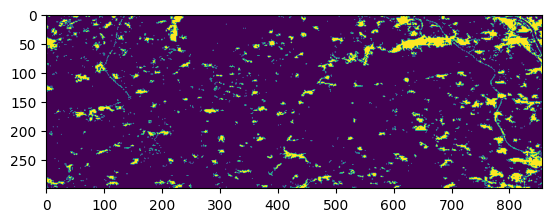

In [208]:
plt.imshow(population)

In [160]:
profile = 'driving-car'
isochrones_parameters = {
    'profile': profile,
    'range_type': 'time',
    'range': [1800],
    'interval': 300,
}

Add the avoided polygons to the parameters for the request after the flood

In [162]:
isochrones_parameters_flood = isochrones_parameters.copy()
isochrones_parameters_flood['options'] = {'avoid_polygons': mapping(affected_roads_bridges_union.make_valid().geometry[0])}

In [168]:
normal_isochrones = []
avoiding_isochrones = []

for i, start in enumerate(range(0, len(physicians), 5)):
    selected_physicians = physicians[start:start+5]
    coordinates = selected_physicians.geometry.map(lambda p: (p.x, p.y)).to_list()

    # Calculate route before the flood
    isochrones_parameters['locations'] = coordinates
    isochrones_normal = ors.isochrones(**isochrones_parameters)
    isochrones_normal_df = gpd.GeoDataFrame().from_features(isochrones_normal).set_crs(epsg=4326)
    #isochrones_normal_df['name'] = isochrones_normal_df.group_index.map(lambda x: selected_physicians.loc[i * 5 + x, 'name'])
    #isochrones_normal_df['id'] = isochrones_normal_df.index
    normal_isochrones.append(isochrones_normal_df)

    # Calculate route after the flood
    try:
        isochrones_parameters_flood['locations'] = coordinates
        isochrones_flood = ors_client_custom.request(url="/v2/isochrones/{}/geojson".format(profile), post_json=isochrones_parameters_flood)        
        isochrones_flood_df = gpd.GeoDataFrame().from_features(isochrones_flood).set_crs(epsg=4326)
        #isochrones_flood_df['name'] = isochrones_flood_df.group_index.map(lambda x: selected_physicians.loc[i * 5 + x, 'name'])
        #isochrones_flood_df['id'] = isochrones_flood_df.index
    except ApiError as e:
        print(e)
        print(f"No isochrones found for {p['name']}")
        continue
        
    avoiding_isochrones.append(isochrones_flood_df)



In [198]:
normal_isochrones_df = pd.concat(normal_isochrones)
normal_isochrones_df = normal_isochrones_df.dissolve(by='value').reset_index()
avoiding_isochrones_df = pd.concat(avoiding_isochrones)
avoiding_isochrones_df = avoiding_isochrones_df.dissolve(by='value').reset_index()

In [382]:
m = folium.plugins.DualMap(location=badneuenahr_coordinates[::-1], layout='vertical', 
                           tiles='cartodbpositron', zoom_start=8)
m.get_name
normal_isochrones_df.sort_values('value', ascending=False).explore(m=m.m1, 
                                                                   column='value', 
                                                                    style_kwds={'stroke':False, 'fillOpacity':0.2},
                                                                   cmap='plasma')
avoiding_isochrones_df.sort_values('value', ascending=False).explore(m=m.m2, 
                                                                     column='value',
                                                                    style_kwds={'stroke':False, 'fillOpacity':0.2},
                                                                     cmap='plasma', legend=False)
physicians.explore(m=m)
affected_roads_bridges.explore(m=m.m2, color='blue')

Any pattern you spot right away?

## Combine isochrones with population counts by municipality boundaries

The next step in our analysis involves overlaying and intersecting the isochrone intervals obtained from openrouteservice with municipality boundaries. This allows us to examine the impact of the flood damage on the catchments of physicians in the Ahr Valley area. By performing this intersection, we can identify the areas within each municipality that fall within specific travel time intervals, indicating the accessibility of physicians before and after the flood.

Once we have the intersected shapes, we aim to enrich them with population information from the WorldPop dataset. This additional data will provide insights into the population residing within each isochrone interval and municipality, helping us assess the potential impact of the flood on healthcare accessibility for different population groups.

To achieve this, we will utilize the "exactextract" package, which offers zonal statistic methods. These methods enable us to calculate summary statistics within each zone or polygon, in this case, the intersected shapes. By applying the zonal statistic methods, we can derive population-related information such as total population, population density, or any other relevant demographic indicators within each zone.

In [327]:
mun_iso_normal = gpd.overlay(municipalities, normal_isochrones_df, how='intersection')

In [328]:
mun_iso_avoiding = gpd.overlay(municipalities, avoiding_isochrones_df, how='intersection')

In [329]:
#mun_iso_normal.sort_values('value', ascending=False).explore(column='value', cmap='plasma')

In [330]:
municipalities['total_pop'] = pd.DataFrame(
    zonal_stats(
        vectors=municipalities, 
        raster="../resources/data/ahrtal/wpop_ahrvalley.tif", 
        stats='sum'))

In [331]:
mun_iso_normal['pop'] = pd.DataFrame(
    zonal_stats(
        vectors=mun_iso_normal['geometry'], 
        raster="../resources/data/ahrtal/wpop_ahrvalley.tif", 
        stats='sum'
    )
)['sum']
mun_iso_normal['scenario'] = 'normal'
mun_iso_avoiding['pop'] = pd.DataFrame(
    zonal_stats(
        vectors=mun_iso_avoiding['geometry'], 
        raster="../resources/data/ahrtal/wpop_ahrvalley.tif", 
        stats='sum'
    )
)['sum']
mun_iso_avoiding['scenario'] = 'avoiding'

In [332]:
mun_iso = pd.concat([mun_iso_normal, mun_iso_avoiding], axis=0)

In [333]:
municipalities.set_index('name', inplace=True)

In [334]:
mun_iso['pop_%'] = mun_iso.apply(lambda row: row['pop'] / municipalities.loc[row['name'], 'total_pop'] * 100 , axis=1) # / municipalities.loc[row['name', 'total_pop']]

Calculate percentage of population covered

In [343]:
mun_iso.sort_values('name', inplace=True)

/Users/cludwig/Documents/conferences/2023_FOSS4G/workshop/openrouteservice-examples/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


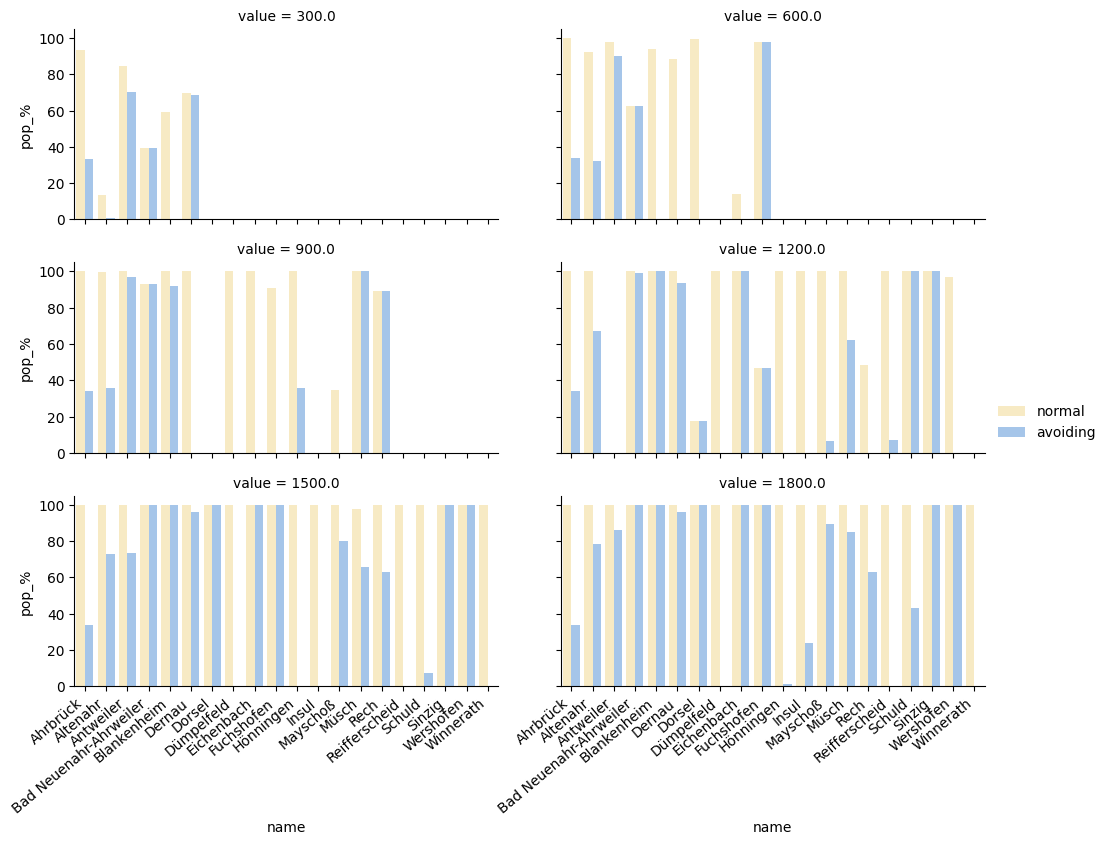

In [347]:
pal = dict(normal="#FFEEBB", avoiding='#9AC5F4')
g = sns.FacetGrid(mun_iso, col='value', sharex=True, col_wrap=2, height=2.5, aspect=2, palette=pal)
g.map(sns.barplot, 'name', 'pop_%', 'scenario', palette=pal, hue_order=['normal', 'avoiding'])
g.axes[-1].set_xticklabels(g.axes[-1].get_xticklabels(), rotation=40, ha='right')
g.axes[4].set_xticklabels(g.axes[-1].get_xticklabels(), rotation=40, ha='right')
g.add_legend()

In [370]:
scenario = 'avoiding'
distance = 1800
mun_iso.sort_values('value', ascending=False, inplace=True)
mun_iso.loc[(mun_iso['value'] == distance) & (mun_iso['scenario'] == scenario)].explore(column='pop_%', cmap='plasma')

# Analysis and evaluation

By combining the isochrone intervals, municipality boundaries, and population data, we can gain a comprehensive understanding of the changes to physician catchments and healthcare accessibility after the flood. This information will be crucial in identifying areas where population needs may have increased due to infrastructure damage, and aid in planning targeted relief efforts and healthcare resource allocation. But a table is hard to extract insights from. Therefore we create a bar plot comparing the amount of people within a isochrone interval for every municipality.